In [1]:
import mdtraj as md
import glob as glob
from scipy import spatial
from collections import defaultdict
from tqdm import tqdm_notebook
import numpy as np
import os

In [2]:
def hydrophicity_clusterer(files, threshold=0.5, interchain=True, intraresidue=False, 
                           hydrophobicity_map=None, h_threshold=0.0, debug=True):
    
    """
    Function to calculate the number of contacts each residue has hydrophobic and hydrophilic residues.
    As a convention values above h_threshold are considered hydrophobic and others hydrophilic.
    
    v0.1: First version, based on clusterer
   
    :type threshold: float
    :type interchain: bool
    :type intraresidue: bool
    :hydrophobicity_map: dict
    :h_threshold: float
    :type debug: bool
    
    :param directory: files to run calculation
    :param threshold: threshold in nm in contact definition
    :param interchain: whether to look at interchain contacts
    :param intraresidue: whether to look for interactions within the same residue
    :param debug: switch on debug mode
    :param hydrophobicity_map: dictionary with hydrophobicity scores
    :param h_threshold: hydrohobicity threshold
    
    :rtype: dict
    :return: a dict with dictionaries with the contacts for each each residue.
             Each position has a list with two entries:
             - element 0: is there a hydrophilic contact
             - element 1: is there a hydrophobic contact
    
    Pseudocode:
    ----------
        1. for each file in directory:
            a. Read PDB to extract residue names
            b. Parse file with mdtraj
            c. initialise contacts dict
            d. Calculate dense matrix with euclidean distances and then convert to squareform
            f. for each position below threshold:
                i. Find out position of corresponding atom
               ii. Find out if it is hydrophobic or hydrophilic and store in 2 dimensional vector
        2. Return dict (with key corresponding to file) with contacts of each file
    """
    
    if hydrophobicity_map is None:
        raise ValueError("Unspecified hydrophobicity map!")
        
    if len(hydrophobicity_map) != 20:
        raise ValueError("hydrophobicity_map requires 20 keys, one for each amino acid!")
        
    result = dict()
    
    for file in tqdm_notebook(files):
        
        file_name = os.path.split(file)[-1].split('.')[0] # get file basename
                
        seq=list()

        atom_map = dict()

        with open(file, 'r') as f:
            file_length = 0
            i=0
            for line in f.readlines():

                line_el = line.split()


                if len(line_el) < 6:
                    continue

                try:
                    if line_el[2] not in ['N', 'O', 'CA', 'C']:
                        file_length += 1
                        atom_map[i] = (line_el[4], line_el[5], line_el[3])
                        i+=1

                    if (line_el[4], line_el[5]) not in seq:
                        seq.append((line_el[4], line_el[5]))
                except:
                    raise ValueError(line)

        result_i = dict()

        model = md.load_pdb(file)

        model = model.atom_slice(model.top.select('all and sidechain'))

        atoms = model.n_atoms

        contacts = defaultdict(lambda: [0, 0])

        dists = spatial.distance.pdist(model.xyz.squeeze(0))

        dist_threshold = np.where(spatial.distance.squareform(dists) < threshold)

        for atom1, atom2 in zip(dist_threshold[0], dist_threshold[1]):

            position1 = atom_map[atom1][0]+atom_map[atom1][1]
            position2 = atom_map[atom2][0]+atom_map[atom2][1]
            
            if not interchain and position1[0] != position2[0]:
                # if atoms are in different chains skip
                continue
                
            if not intraresidue and position1 == position2:
                # skip if atoms are in same residue
                continue
                
            if not isinstance(position1, str) or not isinstance(position2, str):
                # skip position to handle errors
                continue
            if hydrophobicity_map[atom_map[atom1][-1]] <= h_threshold:
                contacts[position1][0] = 1
            else:
                contacts[position1][1] = 1
                
        result[file_name] = contacts
                
    return result

In [3]:
def parse_hydrophobicity(file):
    
    scores = dict()
    
    with open(file, 'r') as f:
        for line in f:
            if line.startswith('!'):
                continue
                
            el = line.split()
            if len(el) > 1:
            
                scores[el[0]] = float(el[1])
            
    return scores

In [4]:
consensus_H = parse_hydrophobicity('../Hydrophobicity/data/consensus.hpb')

In [5]:
files = glob.glob('../models/*pdb')
result = hydrophicity_clusterer(files, 0.5, hydrophobicity_map=consensus_H, h_threshold=0,debug=False)

HBox(children=(IntProgress(value=0, max=900), HTML(value='')))

In [6]:
import json

with open('/home/gil/AbPyTools/abpytools/data/NumberingSchemes.json') as f:
    data = json.load(f)['chothia']
    heavy_data = data['heavy']
    light_data = data['light']
    
    numbering_data = [*heavy_data, *light_data]

In [7]:
def vector_representation(data, order):
    """
    Function to represent cluster data in matrix form
    
    :type data: dict
    
    :param data: data from clusterer
    
    :rtype: dict
    :return: returns dict with same keys as data containing a dict 
             with the vector for each position
             
    Explanation:
    ------------
    
    Each vector has the following order:
    
    [hydrophobic_contact, hydrophilic_contact]
    
    Each elemeent either takes up the value of 0 (no contact) or 1 (contact)
    
    """
    
    result = dict()
    
    for key, value in tqdm_notebook(data.items()):
        
        file_result = dict()
        
        for pos in order:
            
            file_result[pos] = value[pos]
            
        result[key] = file_result
                
    return result

In [8]:
result_matrix = vector_representation(result, numbering_data)

HBox(children=(IntProgress(value=0, max=900), HTML(value='')))

In [9]:
import pandas as pd

In [10]:
hydrophobicity_pd = pd.DataFrame(result_matrix).T

In [11]:
hydrophobicity_pd.head()

,H1,H10,H100,H100A,H100B,H100C,H100D,H100E,H100F,H100G,...,L95A,L95B,L95C,L95D,L95E,L95F,L96,L97,L98,L99
P1,"[1, 0]","[1, 0]","[0, 0]","[0, 1]","[0, 1]","[1, 0]","[0, 1]","[0, 1]","[0, 1]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[1, 0]","[1, 0]","[0, 1]","[0, 0]"
P10,"[0, 0]","[1, 0]","[1, 0]","[0, 1]","[1, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 1]","[1, 0]","[0, 1]","[0, 0]"
P100,"[1, 0]","[0, 0]","[0, 1]","[1, 0]","[1, 0]","[1, 0]","[0, 1]","[0, 0]","[0, 0]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[1, 0]","[1, 0]","[0, 1]","[0, 0]"
P101,"[1, 0]","[0, 0]","[1, 0]","[0, 1]","[0, 1]","[0, 1]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 1]","[1, 0]","[0, 1]","[0, 0]"
P102,"[0, 0]","[1, 0]","[0, 1]","[0, 1]","[1, 0]","[0, 1]","[0, 1]","[1, 0]","[1, 0]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[1, 0]","[1, 0]","[0, 1]","[0, 0]"


In [12]:
hydrophobicity_pd.tail()

,H1,H10,H100,H100A,H100B,H100C,H100D,H100E,H100F,H100G,...,L95A,L95B,L95C,L95D,L95E,L95F,L96,L97,L98,L99
P95,"[1, 0]","[0, 0]","[1, 0]","[0, 1]","[0, 1]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[1, 0]","[1, 0]","[0, 1]","[0, 0]"
P96,"[0, 0]","[1, 0]","[1, 0]","[0, 1]","[1, 0]","[0, 1]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",...,"[1, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[1, 0]","[0, 1]","[0, 1]","[0, 0]"
P97,"[0, 0]","[0, 0]","[0, 1]","[0, 1]","[0, 1]","[0, 1]","[0, 1]","[0, 0]","[0, 0]","[0, 0]",...,"[0, 1]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 1]","[1, 0]","[0, 1]","[0, 0]"
P98,"[0, 0]","[0, 1]","[1, 0]","[0, 1]","[0, 0]","[1, 0]","[0, 1]","[1, 0]","[1, 0]","[0, 1]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 1]","[1, 0]","[0, 1]","[0, 0]"
P99,"[0, 0]","[0, 0]","[1, 0]","[0, 0]","[1, 0]","[1, 0]","[1, 0]","[0, 1]","[1, 0]","[0, 1]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[1, 0]","[1, 0]","[0, 1]","[0, 0]"


In [13]:
# convert to binary matrix
# 1 if contact is of hydrophobic nature else 0
hydrophobicity_pd = hydrophobicity_pd.applymap(lambda x: 1 if x[1] > 0 else 0)

In [14]:
from sklearn.decomposition import PCA, TruncatedSVD

In [15]:
pca = PCA()

In [16]:
reduced = pca.fit_transform(hydrophobicity_pd.as_matrix())

In [17]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib
plt.style.use(['seaborn-white', 'seaborn-paper'])
matplotlib.rc("font", family="Times New Roman")

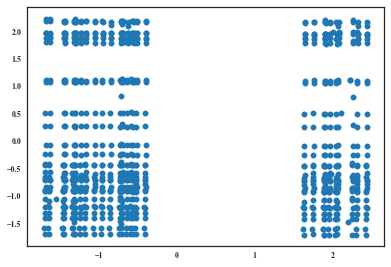

In [18]:
plt.scatter(reduced[:,0], reduced[:,1])

In [19]:
from abpytools import FabCollection, ChainCollection

In [20]:
combinations = pd.read_csv('/home/gil/PhD/Data/UCB/precollection/random_pairs.txt', index_col=0, delimiter=', ')

/home/gil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [21]:
heavy_chains = ChainCollection(path='/home/gil/PhD/Data/UCB/CombinationData/AbFiles/heavy_chains.json')
heavy_chains.load()
light_chains = ChainCollection(path='/home/gil/PhD/Data/UCB/CombinationData/AbFiles/light_chains.json')
light_chains.load()

Loading in antibody objects


HBox(children=(IntProgress(value=0, max=30), HTML(value='')))


Failed to load 0 objects in list
Loading in antibody objects


HBox(children=(IntProgress(value=0, max=30), HTML(value='')))


Failed to load 0 objects in list


In [22]:
heavy_chains_list=[]
light_chains_list=[]

for heavy, light in  combinations['Random Pairs'].str.split('-'):
    heavy_chains_list.append(heavy_chains.get_object(heavy))
    light_chains_list.append(light_chains.get_object(light))    

In [23]:
fab_collection = FabCollection(None, heavy_chains_list, light_chains_list,
                               names=['P' + str(x) for x in combinations.index.tolist()])

In [25]:
fab_collection.germline_identity

HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

Chain   Light                                            Heavy                \
Region   CDR1   CDR2   CDR3    FR1    FR2    FR3  Total   CDR1   CDR2   CDR3   
P1      100.0   66.7  100.0  100.0   88.2   88.9   92.9   75.0   50.0  100.0   
P2       81.8  100.0   66.7   92.3  100.0  100.0   93.9   62.5   87.5   50.0   
P3       63.6   33.3  100.0   96.2   82.4   88.9   86.0  100.0  100.0  100.0   
P4       88.9   66.7   71.4   96.0   88.2   94.4   90.7   87.5   71.4  100.0   
P5      100.0   66.7  100.0  100.0   88.2   88.9   92.9   87.5   70.0   50.0   
P6       66.7  100.0   85.7   88.5  100.0   94.4   91.6   60.0   42.9  100.0   
P7       66.7   66.7   71.4  100.0   94.1  100.0   93.7   87.5   75.0  100.0   
P8       66.7   66.7   71.4  100.0   94.1  100.0   93.7   90.0   57.1  100.0   
P9       66.7   66.7  100.0   96.0   94.1   97.2   93.5   87.5   71.4  100.0   
P10      33.3  100.0   85.7   96.2   88.2   97.2   90.5   75.0   75.0   50.0   
P11      83.3  100.0   85.7  100.0   94.1   94.4   94.7   90.0  100.0    NaN   
P12      66.7  100.0   85.7   88.5  100.0   94.4   91.6   87.5  100.0  100.0   
P13      66.7   66.7   71.4  100.0   94.1  100.0   93.7   40.0   85.7  100.0   
P14      75.0  100.0   57.1   96.2  100.0  100.0   93.1  100.0   85.7  100.0   
P15      88.9   66.7   71.4   96.0   88.2   94.4   90.7   87.5   75.0  100.0   
P16      66.7  100.0  100.0  100.0  100.0   94.4   95.7  100.0  100.0  100.0   
P17      33.3  100.0   85.7   96.2   88.2   97.2   90.5   62.5   62.5  100.0   
P18      63.6   33.3  100.0   96.2   82.4   88.9   86.0   87.5   75.0  100.0   
P19      66.7  100.0  100.0  100.0  100.0   94.4   95.7   62.5  100.0  100.0   
P20      66.7   66.7   83.3  100.0  100.0   91.7   92.6   75.0  100.0  100.0   
P21     100.0  100.0   50.0  100.0  100.0  100.0   95.9   62.5   87.5  100.0   
P22      83.3  100.0   85.7  100.0   94.1   94.4   94.7   60.0   42.9  100.0   
P23     100.0   66.7  100.0  100.0   88.2   88.9   92.9   87.5  100.0  100.0   
P24      66.7   66.7  100.0   96.0   94.1   97.2   93.5   75.0  100.0  100.0   
P25      50.0  100.0   71.4   72.0   82.4   77.8   74.0   87.5   71.4  100.0   
P26      66.7   66.7   71.4  100.0   94.1  100.0   93.7   75.0   50.0  100.0   
P27      88.9   33.3   85.7  100.0   76.5   94.4   89.7   75.0   75.0  100.0   
P28      88.9   66.7   71.4   96.0   88.2   94.4   90.7  100.0   85.7  100.0   
P29      66.7  100.0  100.0  100.0  100.0   94.4   95.7   62.5   87.5  100.0   
P30      88.9   66.7  100.0   92.0  100.0   88.9   91.8   62.5   62.5  100.0   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
P871     66.7  100.0   85.7   88.5  100.0   94.4   91.6  100.0   87.5  100.0   
P872    100.0  100.0   88.9  100.0  100.0   94.4   96.9   75.0  100.0  100.0   
P873     66.7   66.7   83.3  100.0  100.0   91.7   92.6   62.5   62.5  100.0   
P874    100.0  100.0   50.0  100.0  100.0  100.0   95.9  100.0  100.0  100.0   
P875    100.0  100.0   88.9  100.0  100.0   94.4   96.9   87.5   50.0  100.0   
P876     33.3   66.7   60.0   96.2   94.1   94.4   88.2   40.0   85.7  100.0   
P877    100.0  100.0   50.0  100.0  100.0  100.0   95.9  100.0   87.5  100.0   
P878    100.0  100.0  100.0   92.3  100.0  100.0   97.9   62.5   87.5   50.0   
P879     88.9   66.7   71.4   96.0   88.2   94.4   90.7   75.0   75.0  100.0   
P880    100.0   66.7    0.0  100.0   94.1  100.0   94.6   60.0   42.9  100.0   
P881     33.3  100.0   71.4   84.6   82.4   86.1   81.1   60.0   42.9  100.0   
P882     33.3  100.0   71.4   84.6   82.4   86.1   81.1   62.5   62.5  100.0   
P883     33.3  100.0   85.7   96.2   88.2  100.0   91.6   70.0   71.4  100.0   
P884     88.9   66.7  100.0   92.0  100.0   88.9   91.8  100.0   71.4  100.0   
P885     75.0  100.0   57.1   96.2  100.0  100.0   93.1   90.0  100.0    NaN   
P886     33.3  100.0   71.4   84.6   82.4   86.1   81.1   87.5   87.5  100.0   
P887     81.8  100.0   66.7   92.3  100.0  100.0   93.9  100.0  100.0  100.0   


In [26]:
lambda_kappa = fab_collection.germline['Light']['Assignment'].apply(lambda x: 1 if x.startswith('IGL') else 0).values

/home/gil/anaconda3/lib/python3.6/site-packages/abpytools/core/fab_collection.py:164: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df = df.convert_objects(convert_numeric=True)


/home/gil/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The Vega10_r colormap was deprecated in version 2.0. Use tab10_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


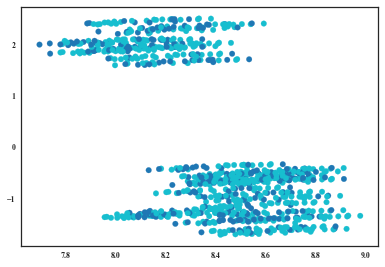

In [27]:
svd = TruncatedSVD()
reduced = svd.fit_transform(hydrophobicity_pd.as_matrix())
plt.scatter(reduced[:,0], reduced[:,1], c=lambda_kappa, cmap='Vega10_r')

In [28]:
hydrophobicity_pd.describe()

,H1,H10,H100,H100A,H100B,H100C,H100D,H100E,H100F,H100G,...,L95A,L95B,L95C,L95D,L95E,L95F,L96,L97,L98,L99
count,900.0,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,...,900.000000,900.000000,900.0,900.0,900.0,900.0,900.00000,900.000000,900.0,900.0
mean,0.0,0.063333,0.296667,0.527778,0.433333,0.300000,0.500000,0.266667,0.170000,0.170000,...,0.100000,0.066667,0.0,0.0,0.0,0.0,0.60000,0.333333,1.0,0.0
std,0.0,0.243697,0.457042,0.499505,0.495811,0.458512,0.500278,0.442463,0.375842,0.375842,...,0.300167,0.249583,0.0,0.0,0.0,0.0,0.49017,0.471667,0.0,0.0
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,1.0,0.0
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,1.0,0.0
50%,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,1.00000,0.000000,1.0,0.0
75%,0.0,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,1.00000,1.000000,1.0,0.0
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.0,0.0,0.0,0.0,1.00000,1.000000,1.0,0.0


In [29]:
from natsort import natsorted

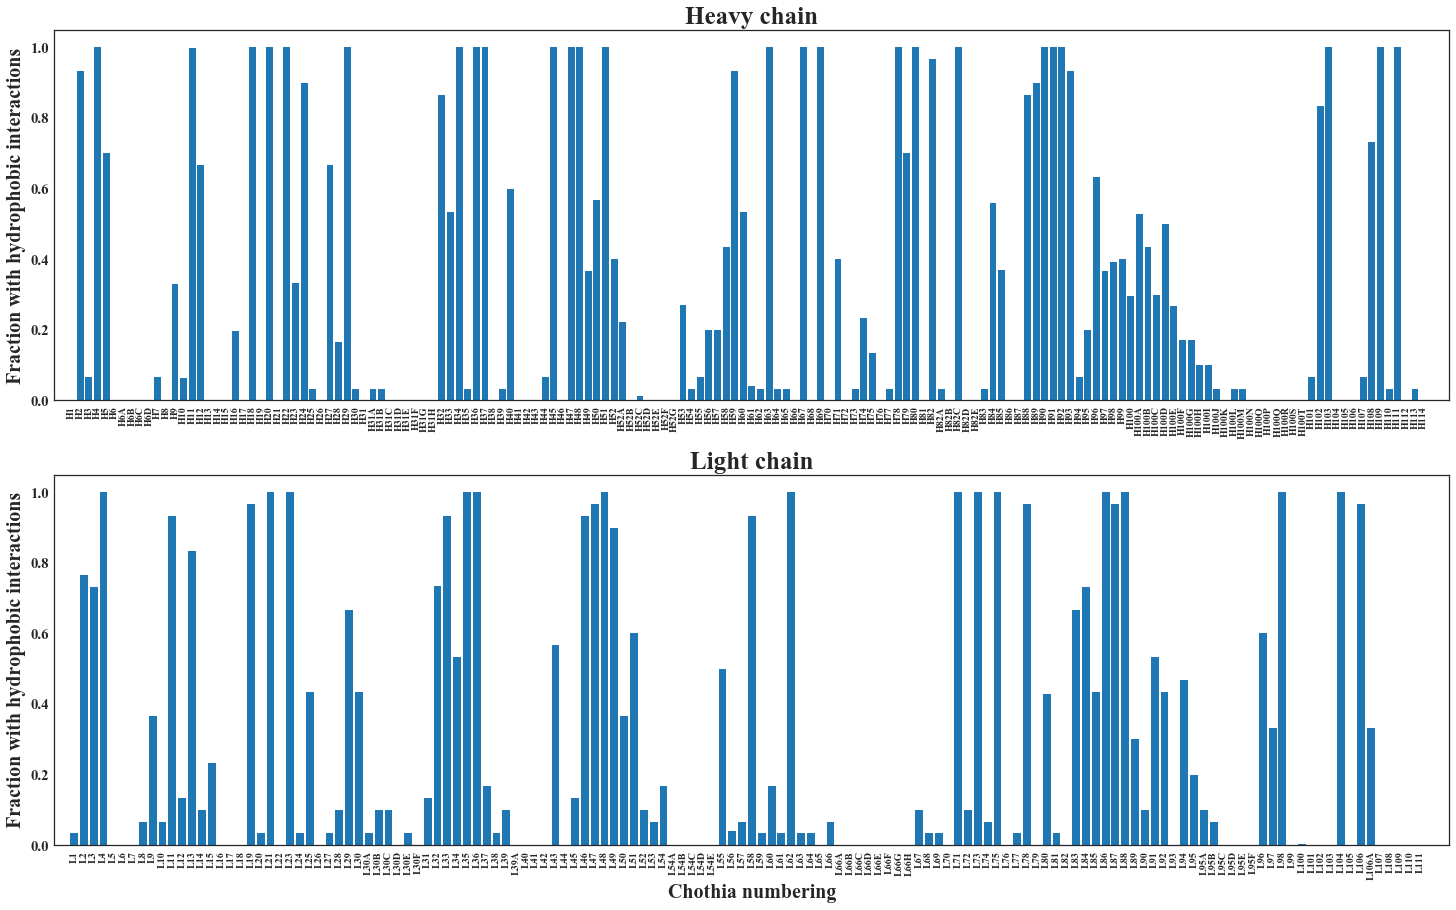

In [30]:
with sns.plotting_context(rc={"axes.titlesize":25,"axes.labelsize":20, 'xtick.labelsize': 10,
                              'ytick.labelsize': 15, 'legend.fontsize': 15}):
    f, ax = plt.subplots(2, 1, figsize=(25, 15))
    
    data = [hydrophobicity_pd[x].mean() for x in natsorted(hydrophobicity_pd.columns) if x.startswith('H')]
    
    ax[0].bar(range(len(data)), data)
    ax[0].set_xticks(range(len(data)))
    ax[0].set_xticklabels([x for x in natsorted(hydrophobicity_pd.columns) if x.startswith('H')], rotation=90)
    ax[0].set_xlim([-2,len(data)+2])
    ax[0].set_title('Heavy chain')
    ax[0].set_ylabel('Fraction with hydrophobic interactions')
    
    data = [hydrophobicity_pd[x].mean() for x in natsorted(hydrophobicity_pd.columns) if x.startswith('L')]
    
    ax[1].bar(range(len(data)), data)
    ax[1].set_xticks(range(len(data)))
    ax[1].set_xticklabels([x for x in natsorted(hydrophobicity_pd.columns) if x.startswith('L')], rotation=90)
    ax[1].set_xlim([-2,len(data)+2])
    ax[1].set_title('Light chain')
    ax[1].set_ylabel('Fraction with hydrophobic interactions')
    ax[1].set_xlabel('Chothia numbering')

In [31]:
data = pd.read_csv('/home/gil/PhD/Data/UCB/Data/Tm/Processed Data/AllTmData.csv', index_col=0)
data.index = ['P' + str(x) for x in data.index]

In [32]:
data.head()

,Tm D - Mean,Tm D - Std. Error,Tm2 - Mean,Tm2 - Std. Error
P2,64.473820,0.000000,NaN,NaN
P3,73.982970,0.130358,NaN,NaN
P4,64.326010,0.060344,NaN,NaN
P6,74.192370,0.036953,NaN,NaN
P9,72.899025,0.085337,NaN,NaN


In [33]:
data = data.join(hydrophobicity_pd)

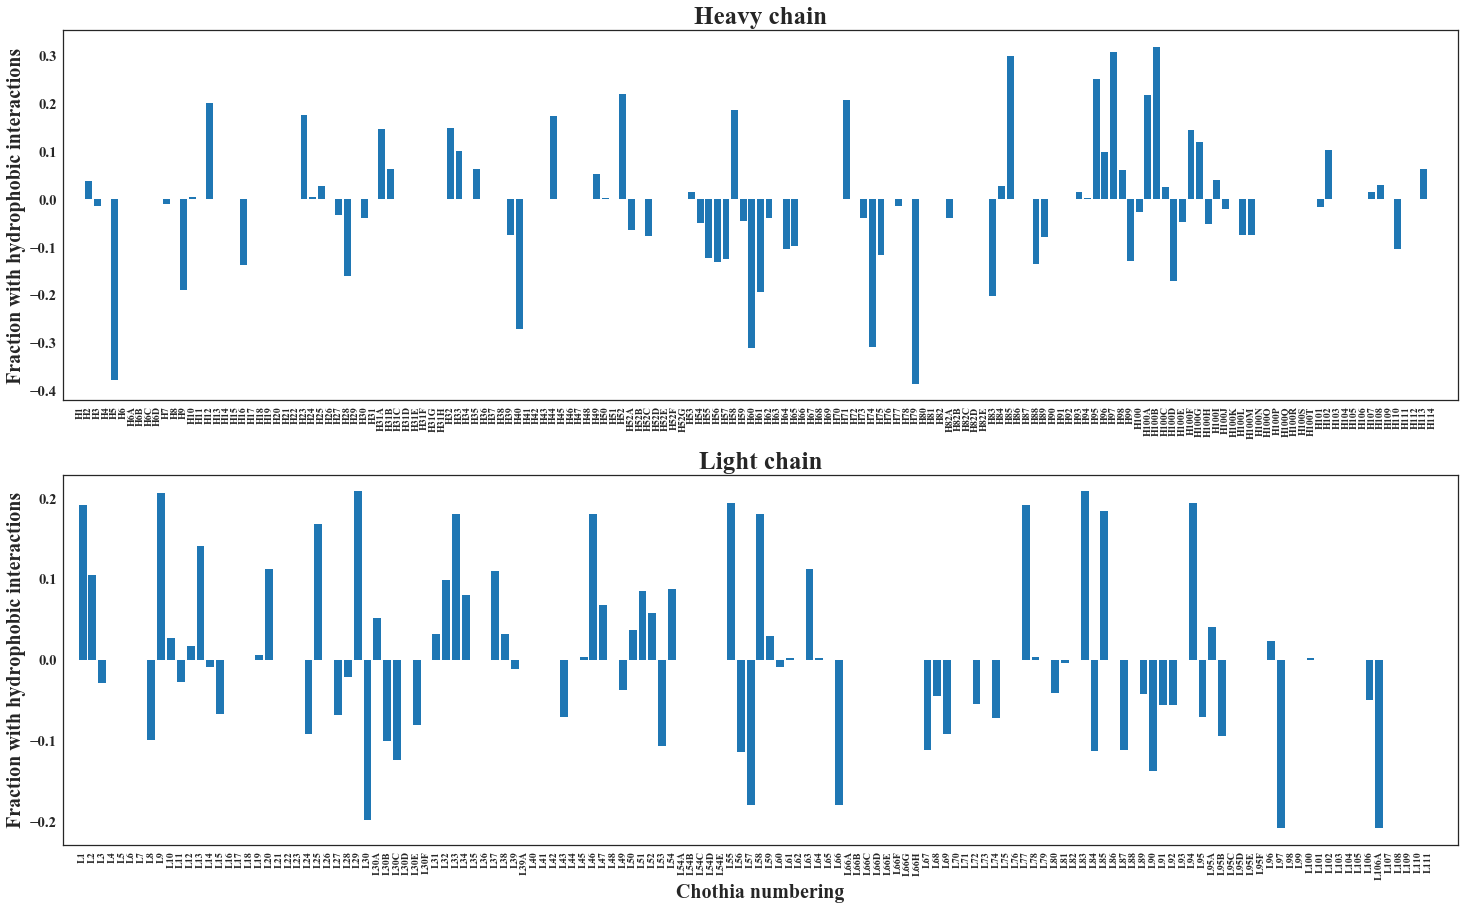

In [34]:
with sns.plotting_context(rc={"axes.titlesize":25,"axes.labelsize":20, 'xtick.labelsize': 10,
                              'ytick.labelsize': 15, 'legend.fontsize': 15}):
    f, ax = plt.subplots(2, 1, figsize=(25, 15))

    data_ = [data[x].corr(data['Tm D - Mean']) for x in natsorted(hydrophobicity_pd.columns) if x.startswith('H')]
     
    ax[0].bar(range(len(data_)), data_)
    ax[0].set_xticks(range(len(data_)))
    ax[0].set_xticklabels([x for x in natsorted(hydrophobicity_pd.columns) if x.startswith('H')], rotation=90)
    ax[0].set_xlim([-2,len(data_)+2])
    ax[0].set_title('Heavy chain')
    ax[0].set_ylabel('Fraction with hydrophobic interactions')
    
    data_ = [data[x].corr(data['Tm D - Mean']) for x in natsorted(hydrophobicity_pd.columns) if x.startswith('L')]
    
    ax[1].bar(range(len(data_)), data_)
    ax[1].set_xticks(range(len(data_)))
    ax[1].set_xticklabels([x for x in natsorted(hydrophobicity_pd.columns) if x.startswith('L')], rotation=90)
    ax[1].set_xlim([-2,len(data_)+2])
    ax[1].set_title('Light chain')
    ax[1].set_ylabel('Fraction with hydrophobic interactions')
    ax[1].set_xlabel('Chothia numbering')

In [35]:
data = data.join(pd.DataFrame(reduced, index = fab_collection.names,columns=['PC1', 'PC2']))

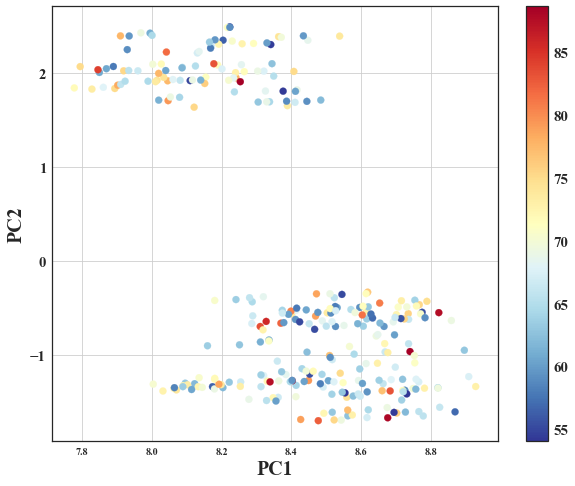

In [36]:
with sns.plotting_context(rc={"axes.titlesize":25,"axes.labelsize":20, 'xtick.labelsize': 10,
                              'ytick.labelsize': 15, 'legend.fontsize': 15}):
    f, ax = plt.subplots(1, 1, figsize=(10, 8))

    svd = TruncatedSVD()
    reduced = svd.fit_transform(hydrophobicity_pd.as_matrix())
    plt.scatter(data['PC1'], data['PC2'], c=data['Tm D - Mean'], cmap='RdYlBu_r', s=50)
    plt.colorbar()
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    
    plt.grid()

In [37]:
data = data[~np.isnan(data['Tm D - Mean'])]

X = data.ix[:,4:-2].values.astype('float').tolist()
y = data['Tm D - Mean'].values.tolist()

/home/gil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [58]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1, l2, l1_l2

In [67]:
X_train, X_test, y_train, y_test = train_test_split(data.ix[:,4:-2].values, data['Tm D - Mean'].values, 
                                                    test_size=0.3, random_state=1970)

model = Sequential()
model.add(Dense(1, input_dim=data.ix[:,4:-2].shape[1], kernel_regularizer=l1_l2(0.1, 0.01)))
# model.add(BatchNormalization())
# model.add(Dense(1))

model.compile(optimizer='rmsprop', loss='mean_squared_error',metrics=['mse'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1)                 297       
Total params: 297
Trainable params: 297
Non-trainable params: 0
_________________________________________________________________


In [68]:
callbacks = ModelCheckpoint('./bestHydrophobicityClusterModel.h5', save_best_only=True)

history = model.fit(X_train, y_train, epochs=2000, validation_data=(X_test, y_test), callbacks=[callbacks])

Train on 212 samples, validate on 92 samples
Epoch 1/2000
212/212 [==============================] - 0s - loss: 4591.4689 - mean_squared_error: 4589.4051 - val_loss: 4434.8688 - val_mean_squared_error: 4432.8639
Epoch 2/2000
212/212 [==============================] - 0s - loss: 4466.1546 - mean_squared_error: 4464.1744 - val_loss: 4335.7188 - val_mean_squared_error: 4333.7691
Epoch 3/2000
212/212 [==============================] - 0s - loss: 4371.7880 - mean_squared_error: 4369.8538 - val_loss: 4248.9478 - val_mean_squared_error: 4247.0347
Epoch 4/2000
212/212 [==============================] - 0s - loss: 4285.8796 - mean_squared_error: 4283.9771 - val_loss: 4166.5457 - val_mean_squared_error: 4164.6555
Epoch 5/2000
212/212 [==============================] - 0s - loss: 4203.5812 - mean_squared_error: 4201.6950 - val_loss: 4086.7819 - val_mean_squared_error: 4084.9017
Epoch 6/2000
212/212 [==============================] - 0s - loss: 4123.3609 - mean_squared_error: 4121.4807 - val_loss:

212/212 [==============================] - 0s - loss: 132.1619 - mean_squared_error: 119.7856 - val_loss: 114.5915 - val_mean_squared_error: 102.1474
Epoch 99/2000
212/212 [==============================] - 0s - loss: 123.6822 - mean_squared_error: 111.1921 - val_loss: 106.8607 - val_mean_squared_error: 94.3091
Epoch 100/2000
212/212 [==============================] - 0s - loss: 115.9234 - mean_squared_error: 103.3298 - val_loss: 99.5622 - val_mean_squared_error: 86.9026
Epoch 101/2000
212/212 [==============================] - 0s - loss: 108.7549 - mean_squared_error: 96.0515 - val_loss: 93.0715 - val_mean_squared_error: 80.3094
Epoch 102/2000
212/212 [==============================] - 0s - loss: 102.3338 - mean_squared_error: 89.5286 - val_loss: 87.1373 - val_mean_squared_error: 74.2743
Epoch 103/2000
212/212 [==============================] - 0s - loss: 96.5047 - mean_squared_error: 83.5970 - val_loss: 81.8288 - val_mean_squared_error: 68.8684
Epoch 104/2000
212/212 [===============

212/212 [==============================] - 0s - loss: 49.2311 - mean_squared_error: 36.5527 - val_loss: 43.1460 - val_mean_squared_error: 30.4638
Epoch 199/2000
212/212 [==============================] - 0s - loss: 49.0720 - mean_squared_error: 36.4053 - val_loss: 43.0782 - val_mean_squared_error: 30.3991
Epoch 200/2000
212/212 [==============================] - 0s - loss: 48.8448 - mean_squared_error: 36.1725 - val_loss: 43.0077 - val_mean_squared_error: 30.3319
Epoch 201/2000
212/212 [==============================] - 0s - loss: 48.7829 - mean_squared_error: 36.0988 - val_loss: 42.8524 - val_mean_squared_error: 30.2017
Epoch 202/2000
212/212 [==============================] - 0s - loss: 48.6752 - mean_squared_error: 36.0295 - val_loss: 42.7909 - val_mean_squared_error: 30.1424
Epoch 203/2000
212/212 [==============================] - 0s - loss: 48.5174 - mean_squared_error: 35.8657 - val_loss: 42.7015 - val_mean_squared_error: 30.0630
Epoch 204/2000
212/212 [=========================

212/212 [==============================] - 0s - loss: 41.9962 - mean_squared_error: 29.5737 - val_loss: 38.1297 - val_mean_squared_error: 25.6931
Epoch 299/2000
212/212 [==============================] - 0s - loss: 41.9058 - mean_squared_error: 29.4661 - val_loss: 38.0967 - val_mean_squared_error: 25.6607
Epoch 300/2000
212/212 [==============================] - 0s - loss: 41.8254 - mean_squared_error: 29.3848 - val_loss: 38.0145 - val_mean_squared_error: 25.5858
Epoch 301/2000
212/212 [==============================] - 0s - loss: 41.8413 - mean_squared_error: 29.4166 - val_loss: 38.0474 - val_mean_squared_error: 25.6099
Epoch 302/2000
212/212 [==============================] - 0s - loss: 41.8038 - mean_squared_error: 29.3684 - val_loss: 37.9680 - val_mean_squared_error: 25.5376
Epoch 303/2000
212/212 [==============================] - 0s - loss: 41.7357 - mean_squared_error: 29.2950 - val_loss: 37.8599 - val_mean_squared_error: 25.4401
Epoch 304/2000
212/212 [=========================

212/212 [==============================] - 0s - loss: 39.0745 - mean_squared_error: 26.4644 - val_loss: 36.0500 - val_mean_squared_error: 23.4341
Epoch 399/2000
212/212 [==============================] - 0s - loss: 39.0045 - mean_squared_error: 26.3869 - val_loss: 35.9245 - val_mean_squared_error: 23.3168
Epoch 400/2000
212/212 [==============================] - 0s - loss: 38.9717 - mean_squared_error: 26.3617 - val_loss: 35.8330 - val_mean_squared_error: 23.2301
Epoch 401/2000
212/212 [==============================] - 0s - loss: 38.9838 - mean_squared_error: 26.3732 - val_loss: 35.7727 - val_mean_squared_error: 23.1722
Epoch 402/2000
212/212 [==============================] - 0s - loss: 38.9254 - mean_squared_error: 26.3142 - val_loss: 35.7162 - val_mean_squared_error: 23.1183
Epoch 403/2000
212/212 [==============================] - 0s - loss: 38.9362 - mean_squared_error: 26.3286 - val_loss: 35.7160 - val_mean_squared_error: 23.1134
Epoch 404/2000
212/212 [=========================

212/212 [==============================] - 0s - loss: 37.5672 - mean_squared_error: 24.6769 - val_loss: 35.0395 - val_mean_squared_error: 22.1364
Epoch 499/2000
212/212 [==============================] - 0s - loss: 37.5632 - mean_squared_error: 24.6718 - val_loss: 35.0984 - val_mean_squared_error: 22.1858
Epoch 500/2000
212/212 [==============================] - 0s - loss: 37.6021 - mean_squared_error: 24.6822 - val_loss: 34.9873 - val_mean_squared_error: 22.0832
Epoch 501/2000
212/212 [==============================] - 0s - loss: 37.5501 - mean_squared_error: 24.6456 - val_loss: 34.9446 - val_mean_squared_error: 22.0409
Epoch 502/2000
212/212 [==============================] - 0s - loss: 37.5600 - mean_squared_error: 24.6463 - val_loss: 34.8313 - val_mean_squared_error: 21.9390
Epoch 503/2000
212/212 [==============================] - 0s - loss: 37.5457 - mean_squared_error: 24.6510 - val_loss: 34.8967 - val_mean_squared_error: 21.9925
Epoch 504/2000
212/212 [=========================

212/212 [==============================] - 0s - loss: 36.6365 - mean_squared_error: 23.5088 - val_loss: 34.3336 - val_mean_squared_error: 21.1951
Epoch 599/2000
212/212 [==============================] - 0s - loss: 36.6920 - mean_squared_error: 23.5546 - val_loss: 34.2377 - val_mean_squared_error: 21.1085
Epoch 600/2000
212/212 [==============================] - 0s - loss: 36.6498 - mean_squared_error: 23.5144 - val_loss: 34.1974 - val_mean_squared_error: 21.0713
Epoch 601/2000
212/212 [==============================] - 0s - loss: 36.6237 - mean_squared_error: 23.4881 - val_loss: 34.2047 - val_mean_squared_error: 21.0758
Epoch 602/2000
212/212 [==============================] - 0s - loss: 36.6336 - mean_squared_error: 23.5050 - val_loss: 34.2326 - val_mean_squared_error: 21.0965
Epoch 603/2000
212/212 [==============================] - 0s - loss: 36.6462 - mean_squared_error: 23.5067 - val_loss: 34.2320 - val_mean_squared_error: 21.0933
Epoch 604/2000
212/212 [=========================

212/212 [==============================] - 0s - loss: 36.0044 - mean_squared_error: 22.7033 - val_loss: 33.9694 - val_mean_squared_error: 20.6547
Epoch 699/2000
212/212 [==============================] - 0s - loss: 36.0416 - mean_squared_error: 22.7185 - val_loss: 33.8191 - val_mean_squared_error: 20.5194
Epoch 700/2000
212/212 [==============================] - 0s - loss: 36.0047 - mean_squared_error: 22.7011 - val_loss: 33.8210 - val_mean_squared_error: 20.5182
Epoch 701/2000
212/212 [==============================] - 0s - loss: 36.0119 - mean_squared_error: 22.7031 - val_loss: 33.8045 - val_mean_squared_error: 20.5018
Epoch 702/2000
212/212 [==============================] - 0s - loss: 35.9887 - mean_squared_error: 22.6823 - val_loss: 33.8238 - val_mean_squared_error: 20.5170
Epoch 703/2000
212/212 [==============================] - 0s - loss: 36.0217 - mean_squared_error: 22.7043 - val_loss: 33.8162 - val_mean_squared_error: 20.5080
Epoch 704/2000
212/212 [=========================

212/212 [==============================] - 0s - loss: 35.6227 - mean_squared_error: 22.1783 - val_loss: 33.6423 - val_mean_squared_error: 20.1962
Epoch 799/2000
212/212 [==============================] - 0s - loss: 35.6124 - mean_squared_error: 22.1695 - val_loss: 33.7143 - val_mean_squared_error: 20.2594
Epoch 800/2000
212/212 [==============================] - 0s - loss: 35.7213 - mean_squared_error: 22.2530 - val_loss: 33.6491 - val_mean_squared_error: 20.1998
Epoch 801/2000
212/212 [==============================] - 0s - loss: 35.6540 - mean_squared_error: 22.2049 - val_loss: 33.5961 - val_mean_squared_error: 20.1521
Epoch 802/2000
212/212 [==============================] - 0s - loss: 35.6585 - mean_squared_error: 22.2260 - val_loss: 33.6866 - val_mean_squared_error: 20.2317
Epoch 803/2000
212/212 [==============================] - 0s - loss: 35.6201 - mean_squared_error: 22.1636 - val_loss: 33.6271 - val_mean_squared_error: 20.1785
Epoch 804/2000
212/212 [=========================

212/212 [==============================] - 0s - loss: 35.2979 - mean_squared_error: 21.7706 - val_loss: 33.5540 - val_mean_squared_error: 20.0099
Epoch 899/2000
212/212 [==============================] - 0s - loss: 35.3238 - mean_squared_error: 21.7768 - val_loss: 33.5263 - val_mean_squared_error: 19.9843
Epoch 900/2000
212/212 [==============================] - 0s - loss: 35.3180 - mean_squared_error: 21.7709 - val_loss: 33.4493 - val_mean_squared_error: 19.9132
Epoch 901/2000
212/212 [==============================] - 0s - loss: 35.2917 - mean_squared_error: 21.7477 - val_loss: 33.4075 - val_mean_squared_error: 19.8769
Epoch 902/2000
212/212 [==============================] - 0s - loss: 35.2971 - mean_squared_error: 21.7629 - val_loss: 33.4683 - val_mean_squared_error: 19.9304
Epoch 903/2000
212/212 [==============================] - 0s - loss: 35.3404 - mean_squared_error: 21.8090 - val_loss: 33.5355 - val_mean_squared_error: 19.9895
Epoch 904/2000
212/212 [=========================

212/212 [==============================] - 0s - loss: 35.1322 - mean_squared_error: 21.5379 - val_loss: 33.3492 - val_mean_squared_error: 19.7601
Epoch 999/2000
212/212 [==============================] - 0s - loss: 35.0817 - mean_squared_error: 21.4967 - val_loss: 33.4440 - val_mean_squared_error: 19.8438
Epoch 1000/2000
212/212 [==============================] - 0s - loss: 35.0787 - mean_squared_error: 21.4908 - val_loss: 33.4757 - val_mean_squared_error: 19.8713
Epoch 1001/2000
212/212 [==============================] - 0s - loss: 35.0807 - mean_squared_error: 21.4776 - val_loss: 33.3777 - val_mean_squared_error: 19.7822
Epoch 1002/2000
212/212 [==============================] - 0s - loss: 35.0718 - mean_squared_error: 21.4703 - val_loss: 33.3003 - val_mean_squared_error: 19.7148
Epoch 1003/2000
212/212 [==============================] - 0s - loss: 35.0740 - mean_squared_error: 21.4839 - val_loss: 33.2900 - val_mean_squared_error: 19.7042
Epoch 1004/2000
212/212 [====================

212/212 [==============================] - 0s - loss: 34.8671 - mean_squared_error: 21.2557 - val_loss: 33.3558 - val_mean_squared_error: 19.7337
Epoch 1099/2000
212/212 [==============================] - 0s - loss: 34.8682 - mean_squared_error: 21.2408 - val_loss: 33.2673 - val_mean_squared_error: 19.6557
Epoch 1100/2000
212/212 [==============================] - 0s - loss: 34.9105 - mean_squared_error: 21.3033 - val_loss: 33.3517 - val_mean_squared_error: 19.7322
Epoch 1101/2000
212/212 [==============================] - 0s - loss: 34.8763 - mean_squared_error: 21.2586 - val_loss: 33.3847 - val_mean_squared_error: 19.7602
Epoch 1102/2000
212/212 [==============================] - 0s - loss: 34.8802 - mean_squared_error: 21.2580 - val_loss: 33.3150 - val_mean_squared_error: 19.6974
Epoch 1103/2000
212/212 [==============================] - 0s - loss: 34.8679 - mean_squared_error: 21.2572 - val_loss: 33.3376 - val_mean_squared_error: 19.7177
Epoch 1104/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 34.7021 - mean_squared_error: 21.0608 - val_loss: 33.1856 - val_mean_squared_error: 19.5570
Epoch 1199/2000
212/212 [==============================] - 0s - loss: 34.7005 - mean_squared_error: 21.0728 - val_loss: 33.2825 - val_mean_squared_error: 19.6432
Epoch 1200/2000
212/212 [==============================] - 0s - loss: 34.6748 - mean_squared_error: 21.0265 - val_loss: 33.1621 - val_mean_squared_error: 19.5360
Epoch 1201/2000
212/212 [==============================] - 0s - loss: 34.7219 - mean_squared_error: 21.1038 - val_loss: 33.2367 - val_mean_squared_error: 19.6009
Epoch 1202/2000
212/212 [==============================] - 0s - loss: 34.6820 - mean_squared_error: 21.0361 - val_loss: 33.1867 - val_mean_squared_error: 19.5576
Epoch 1203/2000
212/212 [==============================] - 0s - loss: 34.6771 - mean_squared_error: 21.0480 - val_loss: 33.2420 - val_mean_squared_error: 19.6059
Epoch 1204/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 34.5766 - mean_squared_error: 20.9276 - val_loss: 33.2359 - val_mean_squared_error: 19.5957
Epoch 1299/2000
212/212 [==============================] - 0s - loss: 34.5341 - mean_squared_error: 20.8947 - val_loss: 33.2076 - val_mean_squared_error: 19.5705
Epoch 1300/2000
212/212 [==============================] - 0s - loss: 34.5442 - mean_squared_error: 20.9112 - val_loss: 33.2666 - val_mean_squared_error: 19.6236
Epoch 1301/2000
212/212 [==============================] - 0s - loss: 34.5411 - mean_squared_error: 20.9025 - val_loss: 33.2745 - val_mean_squared_error: 19.6301
Epoch 1302/2000
212/212 [==============================] - 0s - loss: 34.5309 - mean_squared_error: 20.8849 - val_loss: 33.1650 - val_mean_squared_error: 19.5336
Epoch 1303/2000
212/212 [==============================] - 0s - loss: 34.5702 - mean_squared_error: 20.9391 - val_loss: 33.1449 - val_mean_squared_error: 19.5165
Epoch 1304/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 34.4015 - mean_squared_error: 20.7680 - val_loss: 33.2155 - val_mean_squared_error: 19.5838
Epoch 1399/2000
212/212 [==============================] - 0s - loss: 34.4302 - mean_squared_error: 20.7983 - val_loss: 33.1354 - val_mean_squared_error: 19.5130
Epoch 1400/2000
212/212 [==============================] - 0s - loss: 34.4025 - mean_squared_error: 20.7831 - val_loss: 33.2820 - val_mean_squared_error: 19.6427
Epoch 1401/2000
212/212 [==============================] - 0s - loss: 34.4061 - mean_squared_error: 20.7613 - val_loss: 33.1464 - val_mean_squared_error: 19.5227
Epoch 1402/2000
212/212 [==============================] - 0s - loss: 34.4720 - mean_squared_error: 20.8394 - val_loss: 33.1947 - val_mean_squared_error: 19.5655
Epoch 1403/2000
212/212 [==============================] - 0s - loss: 34.3993 - mean_squared_error: 20.7684 - val_loss: 33.1560 - val_mean_squared_error: 19.5307
Epoch 1404/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 34.3099 - mean_squared_error: 20.7077 - val_loss: 33.1903 - val_mean_squared_error: 19.5751
Epoch 1499/2000
212/212 [==============================] - 0s - loss: 34.3098 - mean_squared_error: 20.6911 - val_loss: 33.1090 - val_mean_squared_error: 19.5042
Epoch 1500/2000
212/212 [==============================] - 0s - loss: 34.3353 - mean_squared_error: 20.7334 - val_loss: 33.1047 - val_mean_squared_error: 19.5018
Epoch 1501/2000
212/212 [==============================] - 0s - loss: 34.3183 - mean_squared_error: 20.7159 - val_loss: 33.1297 - val_mean_squared_error: 19.5236
Epoch 1502/2000
212/212 [==============================] - 0s - loss: 34.2951 - mean_squared_error: 20.6885 - val_loss: 33.1324 - val_mean_squared_error: 19.5256
Epoch 1503/2000
212/212 [==============================] - 0s - loss: 34.3110 - mean_squared_error: 20.7069 - val_loss: 33.1232 - val_mean_squared_error: 19.5181
Epoch 1504/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 34.2005 - mean_squared_error: 20.6071 - val_loss: 33.1208 - val_mean_squared_error: 19.5333
Epoch 1599/2000
212/212 [==============================] - 0s - loss: 34.2267 - mean_squared_error: 20.6331 - val_loss: 33.0766 - val_mean_squared_error: 19.4915
Epoch 1600/2000
212/212 [==============================] - 0s - loss: 34.1840 - mean_squared_error: 20.6009 - val_loss: 33.1845 - val_mean_squared_error: 19.5885
Epoch 1601/2000
212/212 [==============================] - 0s - loss: 34.2318 - mean_squared_error: 20.6391 - val_loss: 33.1365 - val_mean_squared_error: 19.5452
Epoch 1602/2000
212/212 [==============================] - 0s - loss: 34.2368 - mean_squared_error: 20.6401 - val_loss: 33.1224 - val_mean_squared_error: 19.5326
Epoch 1603/2000
212/212 [==============================] - 0s - loss: 34.2483 - mean_squared_error: 20.6517 - val_loss: 33.0780 - val_mean_squared_error: 19.4933
Epoch 1604/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 34.1198 - mean_squared_error: 20.5559 - val_loss: 32.9866 - val_mean_squared_error: 19.4255
Epoch 1699/2000
212/212 [==============================] - 0s - loss: 34.1271 - mean_squared_error: 20.5620 - val_loss: 33.0479 - val_mean_squared_error: 19.4802
Epoch 1700/2000
212/212 [==============================] - 0s - loss: 34.1081 - mean_squared_error: 20.5413 - val_loss: 33.0430 - val_mean_squared_error: 19.4768
Epoch 1701/2000
212/212 [==============================] - 0s - loss: 34.1513 - mean_squared_error: 20.5818 - val_loss: 33.0400 - val_mean_squared_error: 19.4742
Epoch 1702/2000
212/212 [==============================] - 0s - loss: 34.1423 - mean_squared_error: 20.5676 - val_loss: 32.9674 - val_mean_squared_error: 19.4105
Epoch 1703/2000
212/212 [==============================] - 0s - loss: 34.1394 - mean_squared_error: 20.5767 - val_loss: 32.9985 - val_mean_squared_error: 19.4391
Epoch 1704/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 34.0466 - mean_squared_error: 20.4872 - val_loss: 33.0565 - val_mean_squared_error: 19.5081
Epoch 1799/2000
212/212 [==============================] - 0s - loss: 34.0485 - mean_squared_error: 20.4882 - val_loss: 32.9522 - val_mean_squared_error: 19.4153
Epoch 1800/2000
212/212 [==============================] - 0s - loss: 34.0791 - mean_squared_error: 20.5318 - val_loss: 32.9078 - val_mean_squared_error: 19.3759
Epoch 1801/2000
212/212 [==============================] - 0s - loss: 34.0582 - mean_squared_error: 20.5234 - val_loss: 33.0014 - val_mean_squared_error: 19.4598
Epoch 1802/2000
212/212 [==============================] - 0s - loss: 34.0084 - mean_squared_error: 20.4665 - val_loss: 33.0419 - val_mean_squared_error: 19.4969
Epoch 1803/2000
212/212 [==============================] - 0s - loss: 34.0678 - mean_squared_error: 20.5214 - val_loss: 33.0489 - val_mean_squared_error: 19.5036
Epoch 1804/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 33.9515 - mean_squared_error: 20.4264 - val_loss: 33.1247 - val_mean_squared_error: 19.5960
Epoch 1899/2000
212/212 [==============================] - 0s - loss: 33.9874 - mean_squared_error: 20.4586 - val_loss: 33.0137 - val_mean_squared_error: 19.4978
Epoch 1900/2000
212/212 [==============================] - 0s - loss: 34.0134 - mean_squared_error: 20.4909 - val_loss: 32.9607 - val_mean_squared_error: 19.4501
Epoch 1901/2000
212/212 [==============================] - 0s - loss: 33.9599 - mean_squared_error: 20.4430 - val_loss: 32.9607 - val_mean_squared_error: 19.4479
Epoch 1902/2000
212/212 [==============================] - 0s - loss: 33.9473 - mean_squared_error: 20.4340 - val_loss: 32.9358 - val_mean_squared_error: 19.4248
Epoch 1903/2000
212/212 [==============================] - 0s - loss: 33.9555 - mean_squared_error: 20.4432 - val_loss: 32.9466 - val_mean_squared_error: 19.4373
Epoch 1904/2000
212/212 [===================

212/212 [==============================] - 0s - loss: 33.9249 - mean_squared_error: 20.4205 - val_loss: 32.9977 - val_mean_squared_error: 19.5074
Epoch 1999/2000
212/212 [==============================] - 0s - loss: 33.9106 - mean_squared_error: 20.4091 - val_loss: 32.9357 - val_mean_squared_error: 19.4520
Epoch 2000/2000
212/212 [==============================] - 0s - loss: 33.9288 - mean_squared_error: 20.4394 - val_loss: 32.9664 - val_mean_squared_error: 19.4791


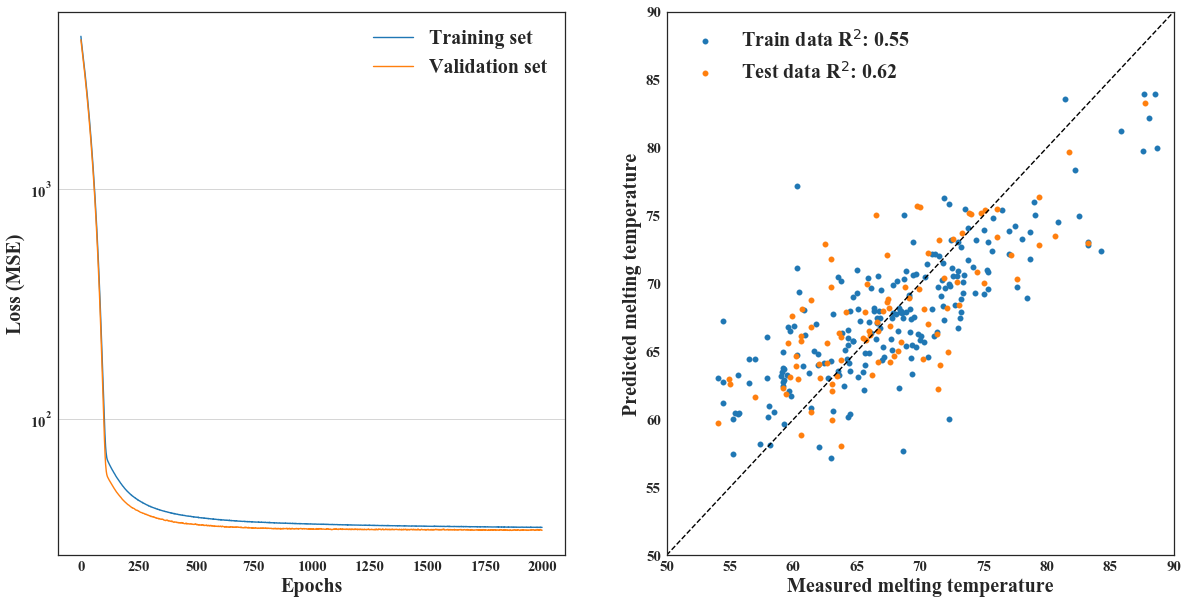

In [69]:
with sns.plotting_context(rc={"axes.titlesize":25,"axes.labelsize":20, 'xtick.labelsize': 15,
                              'ytick.labelsize': 15, 'legend.fontsize': 20}):
    f, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    ax[0].semilogy(history.history['loss'], label='Training set')
    ax[0].semilogy(history.history['val_loss'], label='Validation set')
    ax[0].legend()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss (MSE)')
    ax[0].grid(axis='y')
    
    ax[1].scatter(y_train, model.predict(X_train), label='Train data R$^2$: {:.2f}'.
                  format(r2_score(y_test, model.predict(X_test))))
    ax[1].scatter(y_test, model.predict(X_test), label='Test data R$^2$: {:.2f}'.
                 format(r2_score(y_train, model.predict(X_train))))
    
    ax[1].plot([50, 90], [50, 90], linestyle='--',c='k')
    
    ax[1].set_ylim(50, 90)
    ax[1].set_xlim(50, 90)

#     ax[1].text(56, 81.2,
#              'Test set R$^2$: {:.2f}'.
#              format(r2_score(y_test, model.predict(X_test))),
#              {'size': 20})
#     ax[1].text(56, 83.2,
#              'Training set R$^2$: {:.2f}'.
#              format(r2_score(y_train, model.predict(X_train))),
#              {'size': 20})
    
    ax[1].legend()
    
    ax[1].set_ylabel('Predicted melting temperature')
    ax[1].set_xlabel('Measured melting temperature')

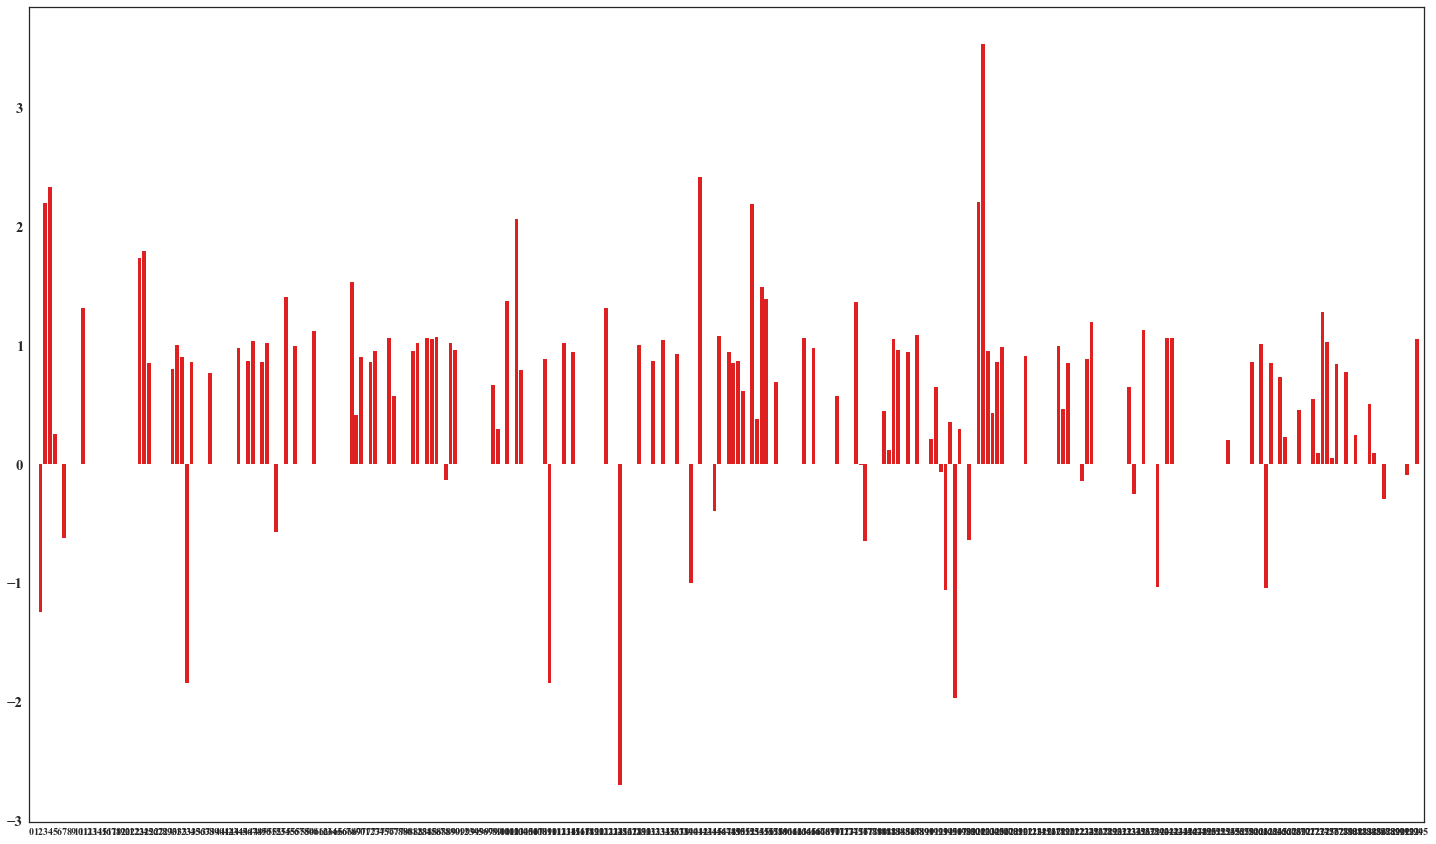

In [70]:
with sns.plotting_context(rc={"axes.titlesize":25,"axes.labelsize":20, 'xtick.labelsize': 10,
                              'ytick.labelsize': 15, 'legend.fontsize': 15}):
    f, ax = plt.subplots(1, 1, figsize=(25, 15))
    sns.barplot(list(range(len(model.layers[0].get_weights()[0]))), model.layers[0].get_weights()[0].reshape(-1),
                color='r')